In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
TRAIN_DIR = ('C:/Users/shahe/Desktop/Glaucoma/Train/')
TEST_DIR = ('C:/Users/shahe/Desktop/Glaucoma/Validation/')

In [3]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of it.

In [4]:
import os
CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['Glaucoma_Negative', 'Glaucoma_Positive'] 
 and the length is : 2


In [5]:
# Image Data Augmentation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [27]:
# Import the images from the train dataset.
# Make sure to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 520 images belonging to 2 classes.


In [28]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
test_set = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 130 images belonging to 2 classes.


In [30]:
# Import the VGG 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [31]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [32]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [33]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [41]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [42]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
 5/17 [=======>......................] - ETA: 2:45 - loss: 11.8871 - acc: 0.2625

KeyboardInterrupt: 

In [30]:
# get sample image to test.
img_normal = image.load_img('C:/Users/shahe/Desktop/Glaucoma/Validation/Glaucoma_Positive/609.jpg', target_size = (224, 224))
img_pneumonia = image.load_img('C:/Users/shahe/Desktop/Glaucoma/Validation/Glaucoma_Negative/483.jpg', target_size = (224, 224))

In [37]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model.predict(x_processed)
    print(np.round_(result))
    if(np.argmax(np.array(result)) == 0):
        result="Glaucoma Negative"
    else:
        result="Glaucoma Positive"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))
    

[[1. 0.]]
[[0. 1.]]


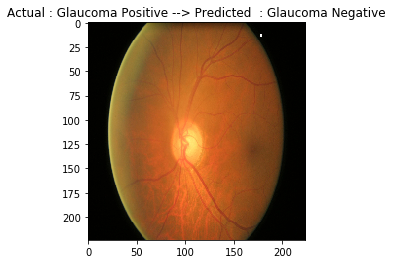

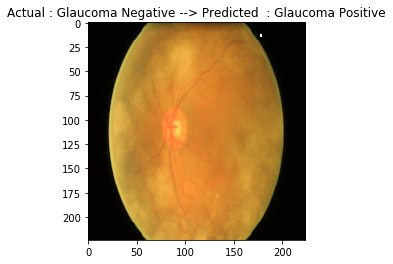

In [38]:
pred_normal = model_predict(img_normal, "Glaucoma Positive")
pred_glaucoma = model_predict(img_pneumonia, "Glaucoma Negative")